<a href="https://colab.research.google.com/github/innovateDotAI/ReadyToUseModels/blob/main/Anamolies_detection_v2_0_forCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we will directly use TS data  to detect anamolies in given snapshot using 2DCNN-AE

# 1. Load the Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

# 2. Load the data and One Hot Encoding

In [ ]:
def rawDataload_TWF():
# Load data from UCI and retrun TS as pandas and list of indexes where failure happends in mfList
  #Data loading and keeping one type of failure
  #First download and import the dataset using pandas:
  import pandas as pd
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'
  #column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                  #'Acceleration', 'Model Year', 'Origin']
  col_name = ['UID','PID','Type','airTemp','processTemp','rotationalSpeed','torque','toolwear','machineFailure','TWF','HDF','PWF','OSF','RNF']
  raw_dataset = pd.read_csv(url, names=col_name,
                            na_values='?', comment='\t',
                            sep=',', skipinitialspace=True,header=0)
  #Drop those rows which will not be part of feature vector:
  rawData = raw_dataset.copy()
  # Create Inliear dataset without any kind of failure
  rawDataInlier = raw_dataset.copy()
  rawDataInlier = rawDataInlier[rawDataInlier["machineFailure"] == 0]
  rawDataInlier.drop(['UID','PID','machineFailure','HDF','OSF','PWF','RNF','TWF'], axis = 1, inplace = True)
  rawDataInlier_oneHot = pd.get_dummies(rawDataInlier, columns=["Type"], prefix=["Type_is"] )

  # Create outlier dataset
  rawDataOutlier = raw_dataset.copy()
  rawDataOutlier = rawDataOutlier[rawDataOutlier["TWF"] == 1]
  rawDataOutlier.drop(['UID','PID','machineFailure','HDF','OSF','PWF','RNF','TWF'], axis = 1, inplace = True)
  rawDataOutlier_oneHot = pd.get_dummies(rawDataOutlier, columns=["Type"], prefix=["Type_is"] )
  return rawDataInlier_oneHot,rawDataOutlier_oneHot,raw_dataset

In [ ]:
def rawDataload_TWF_win():
# Load data from UCI and retrun TS as pandas and list of indexes where failure happends in mfList
  #Data loading and keeping one type of failure
  #First download and import the dataset using pandas:
  import pandas as pd
  url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'
  #column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                  #'Acceleration', 'Model Year', 'Origin']
  col_name = ['UID','PID','Type','airTemp','processTemp','rotationalSpeed','torque','toolwear','machineFailure','TWF','HDF','PWF','OSF','RNF']
  raw_dataset = pd.read_csv(url, names=col_name,
                            na_values='?', comment='\t',
                            sep=',', skipinitialspace=True,header=0)
  #Drop those rows which will not be part of feature vector:
  rawData = raw_dataset.copy()
  # Create raw dataset with only TWF failure and noraml data
  rawData_twf =rawData[(rawData['machineFailure'] == 0) | (rawData['TWF'] == 1)]
  rawData_twf.drop(['UID','PID','machineFailure','HDF','OSF','PWF','RNF'], axis = 1, inplace = True)
  # generate binary values using get_dummies
  raw_dataset_twf_oneHot = pd.get_dummies(rawData_twf, columns=["Type"], prefix=["Type_is"] )
  # Generate failure points:
  rawTS = raw_dataset_twf_oneHot.reset_index(drop=True)
  mfList = rawTS.index[rawTS['TWF'] == 1].tolist()
  return rawTS,mfList

# Train and Test data generation

In [ ]:
def TrainTestData(b1,rawTS,mfList):
  import numpy as np
  raw_np = rawTS.values
  #print("Input shape of rawTS:",raw_np.shape)
  #print("Input mfList values:",mfList)
  X_test = np.empty((0,raw_np.shape[1]), np.float32)
  # Training dataset creation based on windows size
  # initialize outlier data:
  for i in mfList:
    X_test = np.append(X_test, raw_np[i-b1+1:i+1], axis=0)
  #print(X_test.shape)
  X_train = np.copy(raw_np)
  indexList = []
  for i in mfList:
    #print("Index value i:",i)
    tmp = [i for i in range(i-b1+1,i+1)]
    X= [indexList.append(j) for j in tmp]

  #print("Index List:",indexList)
  X_train = np.delete(X_train, indexList, axis=0)
  #print("Shape of X_train after deletion:",X_train.shape)
  #Split features from labels
  #The pop() method removes the specified column from the DataFrame. The pop() method returns the removed columns as a Pandas Series object.
  Y_train = np.copy(X_train)
  Y_test = np.copy(X_test)
  XPopIndex = [5] # Lable value which needs to remove from matrix to generate feature
  YPopIndex = [0,1,2,3,4,6,7,8] # All featrues index value which needs to be removed.
  X_train = np.delete(X_train, XPopIndex, axis=1)
  X_test = np.delete(X_test, XPopIndex, axis=1)
  Y_train = np.delete(Y_train, YPopIndex, axis=1) # Removing label from Traning_set data
  Y_test = np.delete(Y_test, YPopIndex, axis=1)
  return X_train ,Y_train, X_test,Y_test

In [ ]:
import numpy as np
def TS_window(b,n,TS_C):
  # Function Module to convet TS into Sliding wondows based TS
  # b = window size
  #n = number of features in given TS data
  # TS_C = Normalized TS data

  i = 0
  TS_G = np.empty((0,b,n), np.float32)
  for w in range(0,len(TS_C),int(b)):
    #count+=1
    #print("windows")
    win = np.empty((0,n), np.float32)
    for i in range(b):
      try:
      #print("feature vector",w+i,"Values are:",X_train_scaled[w+i])
        win = np.append(win, np.array([TS_C[w+i]]), axis=0)
      except:
        continue
    if win.shape[0] == b:
      TS_G = np.append(TS_G, np.array([win]), axis=0)
  return TS_G

# 2DCNN_AE Model

In [ ]:
def m2_2dcnnae_single_conv(train,e):
  # single layerd CNN AE
  import tensorflow as tf
  from tensorflow import keras
  from keras import layers
  from tensorflow.keras import regularizers
  tf.keras.backend.clear_session()
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  input = keras.Input(shape=(train.shape[1],train.shape[2],1),name='Conv_deconv_singleLayer')
  x_enc = layers.Conv2D(32,kernel_size=(1,3),data_format='channels_last',activation = 'relu',use_bias=True)(input)
  x_enc = layers.Conv2D(128,kernel_size=(1,3),data_format='channels_last',activation = 'relu',use_bias=True)(x_enc)
  encoder = layers.Conv2D(256*2,kernel_size=(1,3),data_format='channels_last',activation = 'relu',use_bias=True)(x_enc)
  x_dec = layers.Conv2DTranspose(128,kernel_size=(1,3),data_format='channels_last',activation = 'relu',use_bias=True)(encoder)
  x_dec = layers.Conv2DTranspose(32,kernel_size=(1,3),data_format='channels_last',activation = 'relu',use_bias=True)(x_dec)
  decoder = layers.Conv2DTranspose(1,data_format='channels_last',activation = 'relu',kernel_size=(1,3))(x_dec)
  model = keras.Model(input,decoder)
  model.compile(optimizer='adam',loss='mean_squared_error')
  history = model.fit(train,train,
                    epochs = e,
                    validation_split = 0.2,
                    shuffle=True,
                    verbose=1,
                    callbacks=[callback]
                    )

  return model,history

In [ ]:
def m3_2dcnnae_single_conv(train,e):
  # single layerd CNN AE
  import tensorflow as tf
  from tensorflow import keras
  from keras import layers
  from tensorflow.keras import regularizers
  tf.keras.backend.clear_session()
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  input = keras.Input(shape=(train.shape[1],train.shape[2],1),name='Deconv_Conv_AE')
  #x = layers.Conv2DTranspose(16,data_format='channels_last',activation = 'relu',kernel_size=(1,5),kernel_regularizer=regularizers.L2(l2=0.00001))(input)
  x = layers.Conv2DTranspose(1,data_format='channels_last',activation = 'relu',kernel_size=(3,5))(input)
  y = layers.Conv2D(1,kernel_size=(3,5),data_format='channels_last',activation = 'relu',use_bias=True)(x)
  model = keras.Model(input,y)
  model.compile(optimizer='adam',loss='mean_squared_error')
  history = model.fit(train,train,
                    epochs = e,
                    validation_split = 0.2,
                    shuffle=True,
                    verbose=0,
                    callbacks=[callback]
                    )

  return model,history

# Model Acurracy Plotting

In [ ]:
def plt_model_accuracy(history):
  # Plot the graphs
  import matplotlib.pyplot as plt
  # Increase size of plot in jupyter

  plt.rcParams["figure.figsize"] = (16,5.5)
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  #acc = list(history.history.keys())[2]
  #val_acc = list(history.history.keys())[3]
  loss = list(history.history.keys())[0]
  val_loss = list(history.history.keys())[1]
  # plt.plot(history.history[acc])
  # plt.plot(history.history[val_acc])
  # plt.title('recreation accuracy')
  # plt.ylabel('accuracy')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'test'], loc='upper left')
  # plt.show()
  # summarize history for loss
  plt.plot(history.history[loss])
  plt.plot(history.history[val_loss])
  plt.title('recreation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Model Analysis

In [ ]:
def model_analysis(train_2,X_test_2,MODEL1):
  import matplotlib.pyplot as plt
  data = train_2
  #data = X_test_2
  y_pred = MODEL1.predict(data)
  y_true = data
  loss=tf.keras.losses.MeanSquaredError()
  inlier_lst= []
  for i in range(len(data)):
    max_val = loss(y_true[i], y_pred[i]).numpy()
    inlier_lst.append(max_val)

  print("Intlier max value:",max(inlier_lst),"Index Val:",inlier_lst.index(max(inlier_lst)))
  data = X_test_2
  outlier_lst = []
  y_pred = MODEL1.predict(data)
  y_true = data
  loss=tf.keras.losses.MeanSquaredError()
  for i in range(len(data)):
    max_val = loss(y_true[i], y_pred[i]).numpy()
    outlier_lst.append(max_val)

  print("outlier max value:",max(outlier_lst),"Index Val:",outlier_lst.index(max(outlier_lst)))
  print("outlier min value:",min(outlier_lst),"Index Val:",outlier_lst.index(min(outlier_lst)))
  # plotting
  plt.figure(figsize=(50,10))
  plt.title("Recreation error graph")
  plt.xlabel("X axis")
  plt.ylabel("Y axis")
  plt.plot(np.array(inlier_lst), color ="green")
  plt.plot(np.array(outlier_lst), color ="red")
  plt.show()
  return inlier_lst,outlier_lst

# Confusion matrix generation

In [ ]:
def confusionMatrix(oc,inlier_lst,outlier_lst):
  Inclass_lable = {}
  Outclass_lable = {}
  count = 0
  print("Total member in inlear:",len(inlier_lst))
  y_pred = []
  for i in range(len(inlier_lst)):
    if oc < inlier_lst[i]:
      y_pred.append(1)
      count+=1
    else:
      y_pred.append(0)
  print("Total False alarm:",count)
  count=0
  print("Total member in Outlier:",len(outlier_lst))
  for i in range(len(outlier_lst)):
    if oc > outlier_lst[i]:
      y_pred.append(0)
      count+=1
    else:
      y_pred.append(1)
  print("Total missed true alarm:",count)
  y_true = [0]*len(inlier_lst)+[1]*len(outlier_lst)
  #Check the classification model strength
  from sklearn.metrics import classification_report
  target_names = ['0','1'] # Need to automate this step later
  y_true_labled = np.array(y_true)
  y_pred_labled = np.array(y_pred)
  #y_predict_ana = yhat_test.astype('int64')
  #print(classification_report(np.array(test_labels.astype('float32'))), test_predictions, target_names=target_names))
  cm = classification_report(y_true_labled, y_pred_labled, target_names=target_names,output_dict=True)
  print(classification_report(y_true_labled, y_pred_labled, target_names=target_names))
  # Note: Precision: TP/(Total predicted positves) , Recall = TP/(Total Actual positves)
  import matplotlib.pyplot as plt
  import numpy
  from sklearn import metrics
  confusion_matrix = metrics.confusion_matrix(y_true_labled, y_pred_labled)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()
  return cm

In [ ]:
# def confusionMatrix(oc,inlier_lst,outlier_lst):
#   Inclass_lable = {}
#   Outclass_lable = {}
#   count = 0
#   print("Total member in inlear:",len(inlier_lst))
#   y_pred = []
#   for i in range(len(inlier_lst)):
#     if oc < inlier_lst[i]:
#       y_pred.append(1)
#       count+=1
#     else:
#       y_pred.append(0)
#   print("Total False alarm:",count)
#   count=0
#   print("Total member in Outlier:",len(outlier_lst))
#   for i in range(len(outlier_lst)):
#     if oc > outlier_lst[i]:
#       y_pred.append(0)
#       count+=1
#     else:
#       y_pred.append(1)
#   print("Total missed true alarm:",count)
#   y_true = [0]*len(inlier_lst)+[1]*len(outlier_lst)
#   #Check the classification model strength
#   from sklearn.metrics import classification_report
#   target_names = ['0','1'] # Need to automate this step later
#   y_true_labled = np.array(y_true)
#   y_pred_labled = np.array(y_pred)
#   #y_predict_ana = yhat_test.astype('int64')
#   #print(classification_report(np.array(test_labels.astype('float32'))), test_predictions, target_names=target_names))
#   cm = classification_report(y_true_labled, y_pred_labled, target_names=target_names,output_dict=True)
#   print(classification_report(y_true_labled, y_pred_labled, target_names=target_names))
#   # Note: Precision: TP/(Total predicted positves) , Recall = TP/(Total Actual positves)
#   return cm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras import regularizers
import numpy as np
e = 1000
# Load the training and test data
train_inlear_all, test_outlier_all,rd = rawDataload_TWF()
train_inlear = train_inlear_all
test_outlier = test_outlier_all
# amplify the diffrences
trn = np.power(train_inlear.values, 3)
tst = np.power(test_outlier.values, 3)

# nomalize by dividing max value of train matrix
max_value = np.max(trn)
print(max_value)
trainN = (trn/max_value)*max_value
testN = (tst/max_value)*max_value

# Generate and train the model
train_2 = trainN.reshape(len(trainN),1,8,1)

19573852375.0


# Main python body

## Tool Wear failure(TWF) machine failure analysis usning UnderComplete CNN-AE over snaphot of data

In [ ]:
# Hyper Parameter input:
b1 = 10 # window size
n = 8 # No. of features
e = 200
# Load Raw Data for CNN-AE
T,mf = rawDataload_TWF_win()
# Create test and training sets
XT,YT,XTs,YTs = TrainTestData(b1,T,mf)
# amplify the diffrences
amp = 1
trn = np.power(XT, amp)
tst = np.power(XTs, amp)

# nomalize by dividing max value of train matrix
max_value = np.max(trn,axis = 0)
print(max_value)
trainN = (trn/max_value)
testN = (tst/max_value)
# Convert data into windows
Tr_w = TS_window(b1,n,trainN) # Numpy windows output of Inliear data
Ts_w = TS_window(b1,n,testN) # Numpy windows output of Outlier data
# Generate and train the model
train_2 = Tr_w.reshape(Tr_w.shape[0],Tr_w.shape[1],Tr_w.shape[2],1)
# Input for  looping:
trecall_max = 0.0
frecall_max = 0.0
count = 0
from google.colab import drive
drive.mount('/content/gdrive')
m1_path = '/content/gdrive/MyDrive/Outlier_model/cnn_m2_undercomplete'
while count < 5:
  m1,history = m2_2dcnnae_single_conv(train_2,e)
  MODEL1 = m1
  X_test_2 = Ts_w.reshape(Ts_w.shape[0],Ts_w.shape[1],Ts_w.shape[2],1)
  # Output analysis
  ## Plot the model training and validation
  print("Loss",list(history.history['loss'])[-1],"Validation Loss:",list(history.history['val_loss'])[-1])
  plt_model_accuracy(history)
  inlier_lst,outlier_lst = model_analysis(train_2,X_test_2,MODEL1)
  #outlier cut-off point:
  oc = min(outlier_lst)
  oc = oc+oc*(1/100)
  mat1 = confusionMatrix(oc,inlier_lst,outlier_lst)
  trecall = mat1['0']['recall']
  frecall = mat1['1']['recall']
  if trecall_max <= trecall and frecall_max <= frecall:
    trecall_max = trecall
    frecall_max = frecall
    count+=1
    print("trecall_max:",trecall_max,'frecall_max:',frecall_max, 'Count:',count)
    m1.save(m1_path)
    if count == 5:
      break

## Tool Wear failure(TWF) machine failure analysis usning OvereComplete CNN-AE over snaphot of data

In [ ]:
# Hyper Parameter input:
b1 = 10 # window size
n = 8 # No. of features
e = 200
# Load Raw Data for LSTM
T,mf = rawDataload_TWF_win()
# Create test and training sets
XT,YT,XTs,YTs = TrainTestData(b1,T,mf)
# amplify the diffrences
amp = 1
trn = np.power(XT, amp)
tst = np.power(XTs, amp)

# nomalize by dividing max value of train matrix
max_value = np.max(trn,axis = 0)
print(max_value)
trainN = (trn/max_value)
testN = (tst/max_value)
# Convert data into windows
Tr_w = TS_window(b1,n,trainN) # Numpy windows output of Inliear data
Ts_w = TS_window(b1,n,testN) # Numpy windows output of Outlier data
# Generate and train the model
train_2 = Tr_w.reshape(Tr_w.shape[0],Tr_w.shape[1],Tr_w.shape[2],1)
# Input for  looping:
trecall_max = 0.0
frecall_max = 0.0
recall_max = 0.0
count = 0
count_loop = 0
from google.colab import drive
drive.mount('/content/gdrive')
m1_path = '/content/gdrive/MyDrive/Outlier_model/m3_2dcnnae_single_conv_v1'
while count_loop < 50:
  m1,history = m3_2dcnnae_single_conv(train_2,e)
  MODEL1 = m1
  X_test_2 = Ts_w.reshape(Ts_w.shape[0],Ts_w.shape[1],Ts_w.shape[2],1)
  # Output analysis
  ## Plot the model training and validation
  print("Loss",list(history.history['loss'])[-1],"Validation Loss:",list(history.history['val_loss'])[-1])
  plt_model_accuracy(history)
  inlier_lst,outlier_lst = model_analysis(train_2,X_test_2,MODEL1)
  #outlier cut-off point:
  oc = min(outlier_lst)
  oc = oc+oc*(1/100)
  mat1 = confusionMatrix(oc,inlier_lst,outlier_lst)
  trecall = mat1['0']['recall']
  frecall = mat1['1']['recall']
  recall = trecall + frecall
  if recall_max <= recall:
    recall_max = recall
    trecall_max = trecall
    frecall_max = frecall
    m1.save(m1_path)
    print("recall_max",recall_max,"\ntrecall_max:",trecall_max,'\nfrecall_max:',frecall_max, '\nCount:',count)
    if count == 5:
      break
    count+=1
  count_loop+=1
  print('Count_loop:',count_loop)

  # if trecall_max <= trecall and frecall_max <= frecall:
  #   trecall_max = trecall
  #   frecall_max = frecall
  #   count+=1
  #   print("trecall_max:",trecall_max,'frecall_max:',frecall_max, 'Count:',count)
  #   m1.save(m1_path)
  #   if count == 5:
  #     break


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[ 304.5  313.8 2695.    70.   246.     1.     1.     1. ]
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Intlier max value: 0.5469615 Index Val: 892
outlier max value: 0.5715435 Index Val: 23
outlier min value: 0.5174647 Index Val: 5


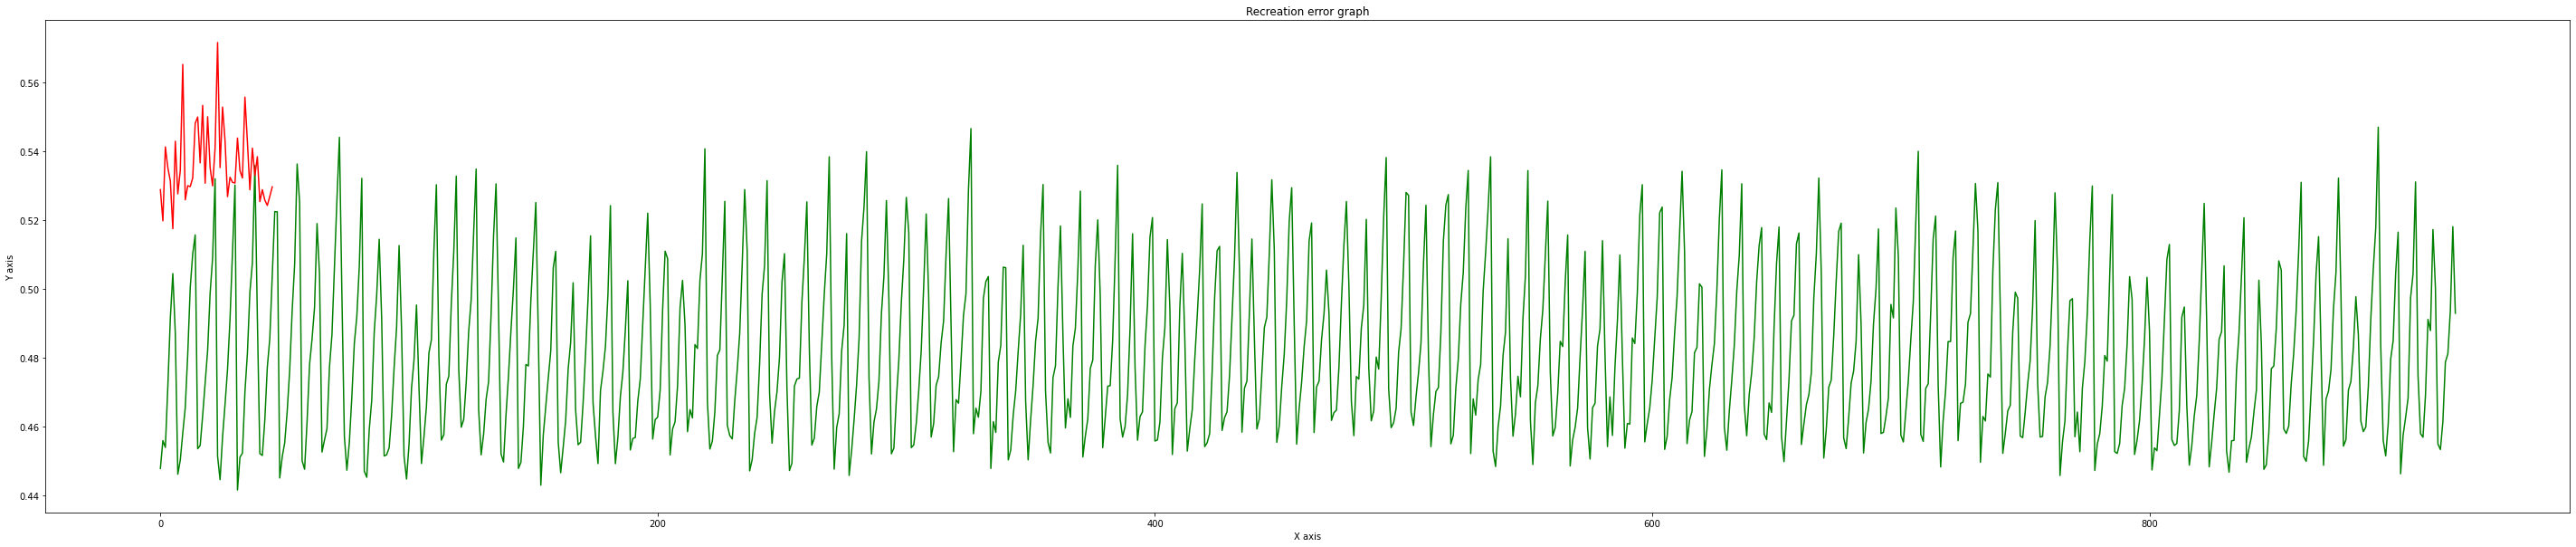

Total member in inlear: 924
Total False alarm: 66
Total member in Outlier: 46
Total missed true alarm: 2
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       924
           1       0.40      0.96      0.56        46

    accuracy                           0.93       970
   macro avg       0.70      0.94      0.76       970
weighted avg       0.97      0.93      0.94       970



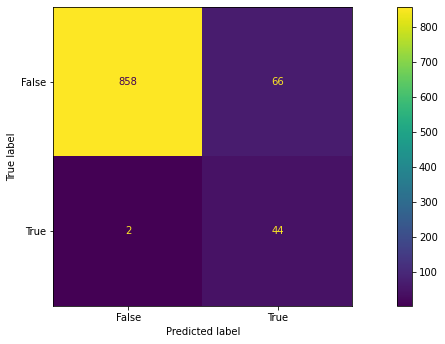

In [ ]:
# Check the perfromance of optimized model saved on drive

# Hyper Parameter input:
b1 = 10 # window size
n = 8 # No. of features
e = 200
# Load Raw Data for LSTM
T,mf = rawDataload_TWF_win()
# Create test and training sets
XT,YT,XTs,YTs = TrainTestData(b1,T,mf)
# amplify the diffrences
amp = 1
trn = np.power(XT, amp)
tst = np.power(XTs, amp)

# nomalize by dividing max value of train matrix
max_value = np.max(trn,axis = 0)
print(max_value)
trainN = (trn/max_value)
testN = (tst/max_value)
# Convert data into windows
Tr_w = TS_window(b1,n,trainN) # Numpy windows output of Inliear data
Ts_w = TS_window(b1,n,testN) # Numpy windows output of Outlier data
# Generate and train the model
train_2 = Tr_w.reshape(Tr_w.shape[0],Tr_w.shape[1],Tr_w.shape[2],1)
X_test_2 = Ts_w.reshape(Ts_w.shape[0],Ts_w.shape[1],Ts_w.shape[2],1)
# Input for  looping:
trecall_max = 0.0
frecall_max = 0.0
recall_max = 0.0
count = 0
count_loop = 0
from google.colab import drive
drive.mount('/content/gdrive')
m1_path = '/content/gdrive/MyDrive/Outlier_model/m3_2dcnnae_single_conv_v1'
m2 = tf.keras.models.load_model(m1_path)
MODEL1 = m2
# Output analysis
## Plot the model training and validation
#print("Loss",list(history.history['loss'])[-1],"Validation Loss:",list(history.history['val_loss'])[-1])
#plt_model_accuracy(history)
inlier_lst,outlier_lst = model_analysis(train_2,X_test_2,MODEL1)
#outlier cut-off point:
oc = min(outlier_lst)
oc = oc+oc*(1/100)
mat1 = confusionMatrix(oc,inlier_lst,outlier_lst)

In [ ]:
# Hyper Parameter input:
b1 = 10 # window size
n = 8 # No. of features
e = 200
# Load Raw Data for LSTM
T,mf = rawDataload_TWF_win()
# Create test and training sets
XT,YT,XTs,YTs = TrainTestData(b1,T,mf)
# amplify the diffrences
amp = 1
trn = np.power(XT, amp)
tst = np.power(XTs, amp)

# nomalize by dividing max value of train matrix
max_value = np.max(trn,axis = 0)
print(max_value)
trainN = (trn/max_value)
testN = (tst/max_value)
# Convert data into windows
Tr_w = TS_window(b1,n,trainN) # Numpy windows output of Inliear data
Ts_w = TS_window(b1,n,testN) # Numpy windows output of Outlier data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[ 304.5  313.8 2695.    70.   246.     1.     1.     1. ]


In [ ]:
print("Shape of Outlier Data:",Ts_w.shape)
print("First Outlier record:\n",Ts_w[0])

Shape of Outlier Data: (46, 10, 8)
First Outlier record:
 [[0.981 0.984 0.544 0.63  0.748 1.    0.    0.   ]
 [0.981 0.984 0.567 0.463 0.768 0.    1.    0.   ]
 [0.982 0.985 0.714 0.323 0.785 0.    0.    1.   ]
 [0.982 0.985 0.539 0.65  0.797 0.    1.    0.   ]
 [0.982 0.985 0.508 0.634 0.805 0.    1.    0.   ]
 [0.982 0.985 0.591 0.5   0.813 0.    1.    0.   ]
 [0.982 0.985 0.594 0.461 0.821 0.    1.    0.   ]
 [0.981 0.984 0.512 0.667 0.829 0.    1.    0.   ]
 [0.981 0.984 0.542 0.684 0.837 0.    1.    0.   ]
 [0.981 0.984 0.54  0.59  0.846 0.    1.    0.   ]]
